# Regularisation

The basic idea of regularisation is to penalise or shrink the large coefficients of a regression model.
This can help with the bias / variance trade-off and can help with model selection by automatically removing irrelevant features.

The shrinkage models that we will see here are the Ridge regression and Lasso.

## An example: predict credit balance

The Credit data set records Balance (average credit card debt for a number of individuals) as well as several quantitative predictors: age, cards (number of credit cards), education (years of education), income (in thousands of dollars), limit (credit limit), and rating (credit rating). In addition to these quantitative variables, we also have four qualitative variables: gender, student (student status), status (marital status), and ethnicity (Caucasian, African American or Asian).

In [4]:
import pandas as pd

# load up the Credit dataset 
#
data = pd.read_csv("../datasets/credit.csv", index_col=0) 

In [5]:
data.shape

(400, 11)

In [6]:
data.columns

Index(['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Gender',
       'Student', 'Married', 'Ethnicity', 'Balance'],
      dtype='object')

In [7]:
data.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [8]:
data.describe()

,Income,Limit,Rating,Cards,Age,Education,Balance
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,45.218885,4735.600000,354.940000,2.957500,55.667500,13.450000,520.015000
std,35.244273,2308.198848,154.724143,1.371275,17.249807,3.125207,459.758877
min,10.354000,855.000000,93.000000,1.000000,23.000000,5.000000,0.000000
25%,21.007250,3088.000000,247.250000,2.000000,41.750000,11.000000,68.750000
50%,33.115500,4622.500000,344.000000,3.000000,56.000000,14.000000,459.500000
75%,57.470750,5872.750000,437.250000,4.000000,70.000000,16.000000,863.000000
max,186.634000,13913.000000,982.000000,9.000000,98.000000,20.000000,1999.000000


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 1 to 400
Data columns (total 11 columns):
Income       400 non-null float64
Limit        400 non-null int64
Rating       400 non-null int64
Cards        400 non-null int64
Age          400 non-null int64
Education    400 non-null int64
Gender       400 non-null object
Student      400 non-null object
Married      400 non-null object
Ethnicity    400 non-null object
Balance      400 non-null int64
dtypes: float64(1), int64(6), object(4)
memory usage: 37.5+ KB


## Prepare training data: features and target

In [10]:
y = data['Balance'].copy() # our target
X = data.copy()
X.drop(['Balance'], axis=1, inplace=True)

## Predict balance from gender (variable with two levels)

Suppose that we wish to investigate differences in credit card balance between males and females, ignoring the other variables for the moment.  
If a qualitative predictor has only two levels then we can simply create an indicator or dummy variable that takes on two possible numerical values.  

We can use the Python _map_ primitive to map Female to 1 and Male to 0.  
Be careful that the labels need to be mapped correctly, eventual spaces included.

In [11]:
X.loc[1, 'Gender']

' Male'

In [12]:
X.Gender = X.Gender.map({'Female':1, ' Male':0})
X.Gender.head()

1    0
2    1
3    0
4    1
5    0
Name: Gender, dtype: int64

The decision to use 0 or 1 is arbitrary and has no effect on the regression fit but different values could result in different coefficients.

We now use the new dummy variable as a predictor in a regression model.

In [13]:
from sklearn import linear_model

#
# : Create the linear regression model 
#
model = linear_model.LinearRegression()

In [14]:
model.fit(X[['Gender']], y)
model.intercept_

509.80310880829012

In [15]:
model.coef_

array([ 19.73312308])

This results in the model:  
Balance = 509.7 if male  
Balance = 509.7 + 19.7 if female  
And 19.7 can be interpreted as the average difference in credit card balance between females and males (females are estimated to carry $19.7 in additional debt for a total of 509.7+19.7 = $529.4).  
However without checking its p-value or confidence intervals (outside the scope of this) we cannot say anything about the statistical evidence of this difference.

## Predict balance from ethnicity (variable with 3 levels)

When a qualitative predictor has more than two levels, a single dummy variable cannot represent all possible values. In this situation, we can  split a categorical variable into additional different binary variables, one for each level.  
For example, for the ethnicity variable we create three dummy variables, using the _pandas_ get_dummies() function.

In [16]:
etno = pd.get_dummies(X['Ethnicity']) # creates extra columns
X = X.join(etno)
X.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,African American,Asian,Caucasian
1,14.891,3606,283,2,34,11,0,No,Yes,Caucasian,0.0,0.0,1.0
2,106.025,6645,483,3,82,15,1,Yes,Yes,Asian,0.0,1.0,0.0
3,104.593,7075,514,4,71,11,0,No,No,Asian,0.0,1.0,0.0
4,148.924,9504,681,3,36,11,1,No,No,Asian,0.0,1.0,0.0
5,55.882,4897,357,2,68,16,0,No,Yes,Caucasian,0.0,0.0,1.0


Since the dummies variable are additional - not new values mapped to the existing variable like for the gender - we can now drop the Ethnicity variable:

In [17]:
X.drop(['Ethnicity'], axis=1, inplace=True)

In [18]:
features = X[['Asian', 'Caucasian', 'African American']]

model.fit(features, y)
model.intercept_

520.60373764246071

In [19]:
model.coef_

array([ -8.29001215,  -2.10625021,  10.39626236])

We see that the estimated balance for the African American is $531.00 = $520.60 + 10.40; it is estimated that the Asian category will have 18.7 dollars less debt than the African American category, and that the Caucasian category will have $12.50 less debt than the African American category. 

Again, no statistical evidence.

## Predict from all variables

First we convert the other two categorical variables:

In [20]:
X.Student = X.Student.map({'Yes':1, 'No':0})
X.Married = X.Married.map({'Yes':1, 'No':0})
X.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,African American,Asian,Caucasian
1,14.891,3606,283,2,34,11,0,0,1,0.0,0.0,1.0
2,106.025,6645,483,3,82,15,1,1,1,0.0,1.0,0.0
3,104.593,7075,514,4,71,11,0,0,0,0.0,1.0,0.0
4,148.924,9504,681,3,36,11,1,0,0,0.0,1.0,0.0
5,55.882,4897,357,2,68,16,0,0,1,0.0,0.0,1.0


Now we implement a naive version of the Forward Stepwise Selection:  
start from a null model and add the next feature with the best score (in terms of square error).

In [21]:
def find_best_feature(X):
    n_features = X.shape[1]
    max_score = 0
    for i in range(n_features):
        feature = X.columns[i]
        X_subset = X[[feature]]
        model.fit(X_subset, y)
        score = model.score(X_subset, y) # R^2 metric
        if score > max_score:
            max_score = score
            max_feature = feature

    return (max_score, max_feature)

find_best_feature(X)

(0.74584841805850366, 'Rating')

In [22]:
n_features = X.shape[1]
scores = [0]
X_selection = X.copy()
X_subsets = pd.DataFrame(index=X.index)

for i in range(n_features):
    (_, next_best_feature) = find_best_feature(X_selection)
    print('Next best feature = {}'.format(next_best_feature))
    X_subset = X_selection[[next_best_feature]]
    X_subsets[next_best_feature] = X_subset

    model.fit(X_subsets, y)
    scores.append(model.score(X_subsets, y))
    
    X_selection.drop([next_best_feature], axis=1, inplace=True)

print(scores)

Next best feature = Rating
Next best feature = Limit
Next best feature = Income
Next best feature = Student
Next best feature = Cards
Next best feature = Gender
Next best feature = African American
Next best feature = Asian
Next best feature = Education
Next best feature = Married
Next best feature = Caucasian
Next best feature = Age
[0, 0.74584841805850366, 0.74594279610140901, 0.87623894562628635, 0.95218750444038314, 0.95416059706123491, 0.95429516950679683, 0.95443993317642362, 0.9544769728962863, 0.95454588366259818, 0.9545969672853537, 0.9545969672853537, 0.95510156336517582]


The first features are Rating, Limit, Income and Student.  
Just with these 4 features, the R2 score is already at 0.95

In [23]:
import matplotlib.pyplot as plt

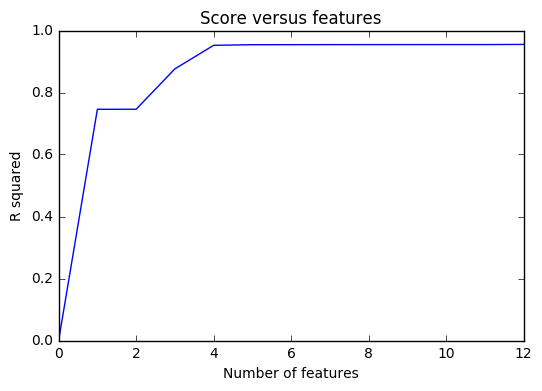

In [24]:
plt.title("Score versus features")
plt.xlabel('Number of features') 
plt.ylabel('R squared')
plt.plot(scores)

The first 4 features are the best predictors, the others do not add too much value.

As we add more and more parameters to our model its complexity increases, which results in increasing variance and decreasing bias, i.e. overfitting.  

Basically there are two methods to overcome overfitting,

- Reduce the model complexity (less features! Use a selection algorithm as the one above and extract a subset of features).
- Regularisation (what we are going to see)

## Regularisation

The subset selection methods use least squares to fit a linear model that contains a subset of the predictors.
As an alternative, we can fit a model containing all _p_ predictors using a technique that constrains or **regularises** the coefficient estimates.

In [25]:
predictors = X.columns
coef = pd.Series(model.coef_,predictors).sort_values()
coef

Education           -10.653248
Gender               -8.970401
African American     -8.533901
Rating               -7.803102
Married              -1.098855
Caucasian            -0.613909
Limit                 0.190907
Income                1.136527
Asian                 1.136624
Student               7.833778
Age                  17.724484
Cards               425.747360
dtype: float64

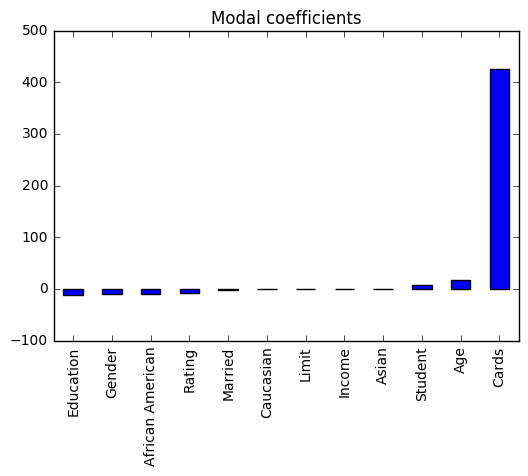

In [26]:
coef.plot(kind='bar', title="Modal coefficients")

We can see that the coefficient of Card is much higher as compared to rest of the coefficients. Therefore the credit balance of a person would be more driven by this feature.

### Ridge Regression

the ridge regression coefficient estimates  ˆR
are the values that minimize ..
As with least squares, ridge regression seeks coe cient estimates that fit the data wePll, by making the RSS small.
• However, the second term,   j  j2, called a shrinkage penalty, is small when  1, . . . ,  p are close to zero, and so it has the e↵ect of shrinking the estimates of  j towards zero.
• The tuning parameter   serves to control the relative impact of these two terms on the regression coe cient estimates.
• Selecting a good value for   is critical; cross-validation is used for this.

SKlearn has a module Ridge to apply a Ridge regression model.  
Let's see an example using lambda = 0.05 (called alpha in SciKitLearn) 

In [27]:
from sklearn.linear_model import Ridge

## training the model
ridgeReg = Ridge(alpha=0.05)

ridgeReg.fit(X, y)

Ridge(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [28]:
ridgeReg.score(X, y)

0.95510140982209057

In [29]:
ridgeReg.coef_

array([ -7.80274243e+00,   1.90788433e-01,   1.13823650e+00,
         1.77125942e+01,  -6.14351757e-01,  -1.09412802e+00,
        -1.06276339e+01,   4.25138458e+02,  -8.56581700e+00,
        -8.97095448e+00,   7.84581065e+00,   1.12514383e+00])

As you can see, the coefficients have been shrinked, and Cards is not sticking out anymore.

### Standardise

The standard least squares coefficient estimates are scale equivariant: multiplying Xj by a constant c simply leads to a scaling of the least squares coefficient estimates by a factor of 1/c.  
In other words, regardless of how the jth predictor is scaled, Xj ˆj will remain the same.
In contrast, the ridge regression coefficient estimates can change substantially when multiplying a given predictor by a constant, due to the sum of squared coefficients term in the penalty part of the ridge regression objective function.  
Therefore, it is best to apply ridge regression after standardizing the predictors.

In [30]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

### how lambda affects the coefficients

Let's plot the coefficients values based on the lambda parameter.

In [31]:
import numpy as np

lambdas = [0.01, 1, 100, 10000]
coefficients = np.zeros(shape=(12, len(lambdas)))
i=0
for l in lambdas:
    ridgeReg = Ridge(alpha=l)
    ridgeReg.fit(X, y)
    coefficients[:,i] = ridgeReg.coef_
    i += 1

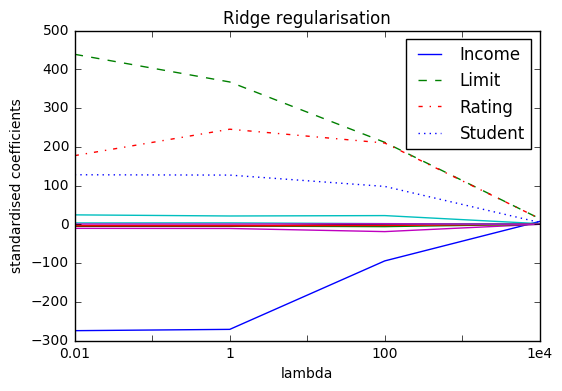

In [32]:
fig, ax = plt.subplots()

plt.title("Ridge regularisation")
plt.xlabel("lambda")
plt.ylabel("standardised coefficients")
styles=['-','--','-.',':']

labels = ['0.01','','1','', '100','', '1e4','']
ax.set_xticklabels(labels) # custom x labels

for i in range(0,12):
    s = styles[i % len(styles)]
    if i<3 or i==7:
        plt.plot(coefficients[i], label=predictors[i], linestyle=s)
    else:
        plt.plot(coefficients[i])

plt.legend(loc='best')

Each curve corresponds to the ridge regression coefficient estimate for one of the variables, plotted as a function of λ.  
At the left side of the plot, λ is essentially zero, and so the corresponding ridge coefficient estimates are the same as the usual least squares estimates. But as λ increases, the ridge coefficient estimates shrink towards zero. When λ is extremely large, then all of the ridge coefficient estimates are basically zero; this corresponds to the null model that contains no predictors.  
In this plot, the income, limit, rating, and student variables are displayed in distinct colours, since these variables are the ones to have the largest coefficient estimates. 

Ridge regression does have one obvious disadvantage.  
Unlike best subset, forward stepwise, and backward stepwise selection, which will generally select models that involve just a subset of the variables, ridge regression will include all p predictors in the final model.  
The penalty λ will shrink all of the coefficients towards zero, but it will not set any of them exactly to zero.  
This may not be a problem for prediction accuracy, but it can create a challenge in model interpretation in settings in which the number of variables p is quite large.  
For example, in the Credit data set, it appears that the most important variables are income, limit, rating, and student. So we might wish to build a model including just these predictors. However, ridge regression will always generate a model involving all ten predictors.  
Increasing the value of λ will tend to reduce the magnitudes of the coefficients, but will not result in exclusion of any of the variables.
The lasso is a relatively recent alternative to ridge regression that over-comes this disadvantage. 

## The lasso

In [33]:
from sklearn.linear_model import Lasso

lassoReg = Lasso(alpha=0.3)

lassoReg.fit(X, y)

Lasso(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [34]:
lassoReg.score(X, y)

0.95509337268728689

In statistical parlance, the lasso uses an L1 penalty instead  of an L2 penalty. 
The L1 penalty has the effect of forcing some of the coefficient estimates to be exactly equal to zero when the tuning parameter λ is sufficiently large. Hence, much like best subset selection, the lasso performs variable selection.  
As a result, models generated from the lasso are generally much easier to interpret than those produced by ridge regression. The lasso yields sparse models — that is, models that involve only a subset of the variables. 

In [35]:
lambdas = [0.01, 1, 10, 50, 100, 200, 500, 1000]
coefficients = np.zeros(shape=(12, len(lambdas)))
i=0
for l in lambdas:
    lassoReg = Lasso(alpha=l)
    lassoReg.fit(X, y)
    coefficients[:,i] = lassoReg.coef_
    i += 1

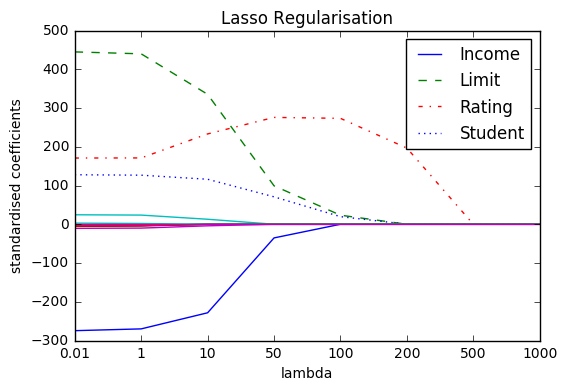

In [36]:
fig, ax = plt.subplots()

plt.title("Lasso Regularisation")
plt.xlabel("lambda")
plt.ylabel("standardised coefficients")
styles=['-','--','-.',':']

labels = ['0.01','1','10','50', '100', '200','500','1000']

ax.set_xticklabels(labels) # custom x labels

for i in range(0,12):
    s = styles[i % len(styles)]
    if i<3 or i==7:
        plt.plot(coefficients[i], label=predictors[i], linestyle=s)
    else:
        plt.plot(coefficients[i])

plt.legend(loc='best')

When λ = 0, the lasso simply gives the least squares fit and when λ becomes sufficiently large, the lasso gives the null model in which all coefficient estimates equal zero.  
However, in between these two extremes, the ridge regression and lasso models are quite different from each other, as you can see from the two plots.

Both in ridge regression and lasso, the tuning parameter serves to control the relative impact of the shrinking terms on the regression coeffcient estimates.  
Selecting a good value for λ is critical; cross-validation is used for this.

## Selecting the Tuning Parameter lambda

Cross-validation provides a simple way to tackle this problem. We choose a grid of λ values, and compute the cross-validation error for each value of λ
We then select the tuning parameter value for which the cross-validation error is smallest. Finally, the model is re-fit using all of the available observations and the selected value of the tuning parameter.

In [38]:
from sklearn.model_selection import cross_val_score, KFold

lambdas = np.linspace(500,0.01,num=50)
scoresCV = []
for l in lambdas:
    lassoReg = Lasso(alpha=l)
    lassoReg.fit(X, y)    
    
    scoreCV = cross_val_score(lassoReg, X, y, scoring='neg_mean_squared_error', 
                             cv=KFold(n_splits=10, shuffle=True,
                                            random_state=1))
    scoresCV.append(np.mean(scoreCV))
        

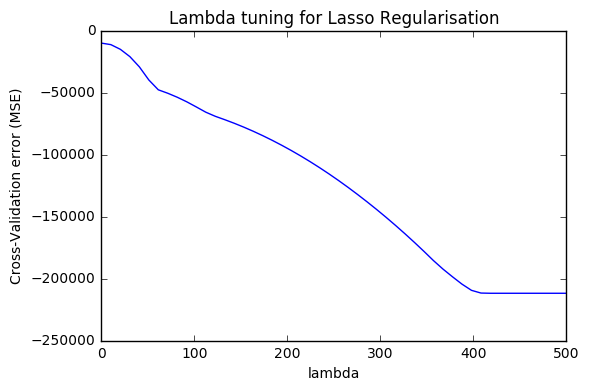

In [39]:
plt.title("Lambda tuning for Lasso Regularisation")
plt.xlabel("lambda")
plt.ylabel("Cross-Validation error (MSE)")

plt.plot(lambdas,scoresCV)

The plot displays how the cross-validation error changes with different values of lambda.
The point at which the cross-validation error is smallest is for very small values of lambda, close to zero.  
Thanks to the sklearn function LassoCV, that applies cross-validation to the Lasso, we can calculate the exact value of lambda that minimise the error:

In [40]:
from sklearn.linear_model import LassoCV

lassoCV = LassoCV()
lassoCV.fit(X,y)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [41]:
lassoCV.alpha_

0.39656269957368379